In [27]:
import sys
from pathlib import Path
path_root = '../'
sys.path.append(str(path_root))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
from utils.ibl_data_loading import (
    load_spiking_data, load_trials_and_mask, merge_probes,
    load_discrete_behaviors, load_continuous_behaviors
)
from utils.ibl_data_processing import prepare_data, select_brain_regions, bin_spiking_data

##### Data Loading Example (Single Session)

In [2]:
# Instantiate ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', 
          silent=True, 
          cache_dir='/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
)
one = ONE(password='international')
ba = AllenAtlas()

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/one/params.py:184: UserWarning: Warning: the directory provided is already a cache for another URL.
  warnings.warn('Warning: the directory provided is already a cache for another URL.')


In [3]:
# List all publicly available sessions
# sessions = one.search()

# List all sessions from the brain-wide-map project
# Note: Not all sessions will have behaviors recorded so we can use sessions 
#       w/ behaviors for supervised tasks and those w/o for SSL
# sessions = one.search(project='brainwide')

# List brainwide map sessions that pass the most important quality controls
# Note: Let's first work with these good quality sessions, and 
#       transition to using more sessions later on
freeze_file = '../data/2023_12_bwm_release.csv'
bwm_df = pd.read_csv(freeze_file, index_col=0)

In [4]:
# Load an example session
idx = 10
pid = bwm_df.pid[idx]
eid, probe = one.pid2eid(pid)

In [5]:
# Load spike sorting data
spikes, clusters = load_spiking_data(one, pid)

In [6]:
# We may not want to train the model with data within trials, but we may need it for eval purposes.
# Load trials data and mask. Trials are excluded in the mask if reaction time is too long or too short,
# or if critical trial events are missing.
trials, mask = load_trials_and_mask(one, eid, min_rt=0.08, max_rt=2., nan_exclude='default')

In [7]:
# Load discrete behaviors for trial decoding
discrete_behaviors = load_discrete_behaviors(trials)
print(discrete_behaviors.keys())

dict_keys(['choice', 'block', 'reward', 'contrast'])


In [8]:
# Load continuous behaviors for any-time decoding
continuous_behaviors = load_continuous_behaviors(one, eid)
print(continuous_behaviors.keys())

dict_keys(['wheel_pos', 'wheel_vel', 'left_whisker', 'right_whisker', 'body_whisker', 'left_pupil', 'right_pupil', 'left_paw_l', 'left_paw_r', 'right_paw_l', 'right_paw_r', 'left_nose', 'right_nose'])


##### Prepare Data for Any-Time Decoding (Single Session)

In [44]:
params = {
    'merged_probes': True,
    # setup for trial decoding:
    'align_time': 'stimOn_times',
    'time_window': (-.2, .8),
    'binsize': 0.02,
    'single_region': False # use all available regions
}

In [10]:
neural_dict, behave_dict, metadata = prepare_data(one, idx, bwm_df, params)

Running merged probes for session eid: 5ec72172-3901-4771-8777-6e9490ca51fc


In [11]:
neural_dict.keys()

dict_keys(['spike_times', 'spike_clusters', 'cluster_regions', 'cluster_qc', 'cluster_df'])

##### Prepare Data for Trial Decoding (In Progress)

In [66]:
brainreg = BrainRegions()
beryl_reg = brainreg.acronym2acronym(neural_dict['cluster_regions'], mapping='Beryl')
regions = ([[k] for k in np.unique(beryl_reg)] if params['single_region'] else [np.unique(beryl_reg)])
print(f"Use spikes from brain regions: ", regions[0])

Use spikes from brain regions:  ['ACAd' 'ACB' 'AON' 'DP' 'ILA' 'LSr' 'LSv' 'MOs' 'OT' 'PL' 'SI' 'TTd'
 'root']


In [67]:
region_cluster_ids = select_brain_regions(neural_dict, beryl_reg, regions[0], **params)

In [68]:
# 'binned_spikes' is very sparse - how to handle the tokenization more efficiently?
binned_spikes, clusters_used_in_bins = bin_spiking_data(region_cluster_ids, neural_dict, trials, **params)

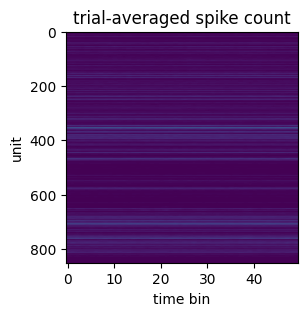

In [71]:
plt.figure(figsize=(3,3))
plt.imshow(np.mean(binned_spikes, 0).T, aspect="auto")
plt.title(f"trial-averaged spike count")
plt.xlabel("time bin")
plt.ylabel("unit");

In [ ]:
# TO DO: Bin behaviors


##### Download and Cache Data  (Multiple Sessions)